# Example of simulation-based model inference (SBMI)
https://arxiv.org/abs/2305.15174

In this notebook we focus on the model inference part. Therefore we only sample from a simple model prior, the graph implementation for the model prior is presented in a later notebook.

### Define model and prior

Similar to the paper we will use an "additive" model: we want to learn a one dimensional function $f(t)$ which can consist of different components, namely:
- linear component: $\theta_1^{1} t$
- linear component:  $\theta_1^{2} t$
- quadratic component: $\theta_1^3 t^2$
- sinusoidal component: $\theta_1^4 \sin(\theta_2^4 t)$
- noise component: $n_{t_i} \sim \mathcal{N}(0, \theta_1^5)$

This results in five model components with in total six parameters, and a partition of the parameter space in $[1,1,1,2,1]$.

The presence/absence of the model components are indicated by a binary vector $M$. 

For simplicity we assume a flat model prior over the component one to three and we assume that the noise term is always present. 

We further assume uniform priors for all parameters $\theta_i^j$. 

In [1]:
import torch
from sbi.utils import get_parameter_mask

import matplotlib.pyplot as plt

In [3]:
n_components = 5

partition = torch.tensor([1, 1, 1, 2, 1])  # partition of the parameters

n_params = partition.sum()

prior_bounds = torch.ones((2, partition.sum()))
prior_bounds[0] = 0.5
prior_bounds[1] = 2
# adapt priors for sine
prior_bounds[0, 3] = 3
prior_bounds[1, 3] = 10
prior_bounds[0, 4] = 1.0
prior_bounds[1, 4] = 5.0


def sample_model_components(n, n_components):
    # the last component is always 1
    m = torch.bernoulli(torch.ones((n, n_components)) * 0.5)
    m[:, -1] = 1
    return m.int()


def sample_parameters(m, prior_bounds, partition):
    n, n_components = m.shape
    thetas = torch.rand((n, prior_bounds.shape[1]))
    # scale the thetas to the prior bounds
    thetas = thetas * torch.abs(prior_bounds[1] - prior_bounds[0]) + prior_bounds[0]
    # mask the parameters that are not used
    mask = ~get_parameter_mask(m, partition)
    thetas[mask] = torch.nan
    return thetas


def run_model(m, thetas):
    n, n_components = m.shape

    thetas = thetas.clone()
    thetas[torch.isnan(thetas)] = 0

    t = torch.arange(0, 10, 0.01)

    # additive model components
    l1 = thetas[:, 0].unsqueeze(1) * t
    l2 = thetas[:, 1].unsqueeze(1) * t
    q = thetas[:, 2].unsqueeze(1) * t**2
    sin = thetas[:, 3].unsqueeze(1) * torch.sin(thetas[:, 4].unsqueeze(1) * t)

    # noise component
    noise = torch.randn(n, len(t)) * thetas[:, 5].unsqueeze(1)

    out = l1 + l2 + q + sin + noise

    return out


# Lets generate some data

t = torch.arange(0, 10, 0.01)

n_train = 5000

m = sample_model_components(n_train, n_components=n_components)
theta = sample_parameters(m, prior_bounds, partition)
x_raw = run_model(m, theta)

m_test = sample_model_components(100, n_components=n_components)
theta_test = sample_parameters(m_test, prior_bounds, partition)
x_raw_test = run_model(m_test, theta_test)

# and bring it to the correct shape for SBMI
x = torch.cat([x_raw, m], dim=1)
x_test = torch.cat([x_raw_test, m_test], dim=1)

We have created the training data $\{M, \theta, x_{raw}\}$ which we will use for training. 
- $M$ has shape (n_samples, n_components)
- $\theta$ has shape (n_samples, sum(partition))
- $x_{raw}$ has shape (n, number of timepoints)

The SBMI method assumes for training that the model vector is appended to $x_{raw}$:
$x = [x_{raw},m]$

So we are left with the training data $\{\theta, M \}$

Let's have a look at the data:

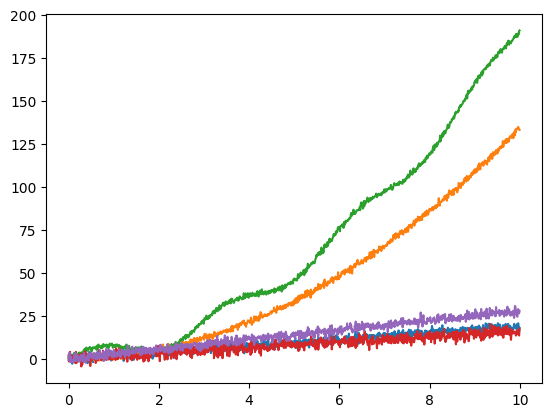

 thetas: tensor([[1.9112,    nan,    nan,    nan,    nan, 1.4233],
        [   nan,    nan, 1.3431,    nan,    nan, 1.0374],
        [1.4909,    nan, 1.7520, 5.4996, 2.2105, 0.8155],
        [1.5935,    nan,    nan,    nan,    nan, 1.8493],
        [1.4527, 1.3354,    nan,    nan,    nan, 1.4441]])


In [4]:
plt.plot(t, x[:5, :-n_components].T)
plt.show()

print(f" thetas:", theta[:5])

In [5]:
# quick check for the parameters
for i in range(partition.sum()):
    print("min, max, mean of parameter", i, ":")
    print(
        theta[~torch.isnan(theta[:, i]), i].min(),
        theta[~torch.isnan(theta[:, i]), i].max(),
        torch.nanmean(theta[:, i]),
    )

min, max, mean of parameter 0 :
tensor(0.5002) tensor(1.9994) tensor(1.2299)
min, max, mean of parameter 1 :
tensor(0.5004) tensor(1.9993) tensor(1.2417)
min, max, mean of parameter 2 :
tensor(0.5001) tensor(1.9989) tensor(1.2560)
min, max, mean of parameter 3 :
tensor(3.0022) tensor(9.9964) tensor(6.5099)
min, max, mean of parameter 4 :
tensor(1.0011) tensor(4.9979) tensor(3.0081)
min, max, mean of parameter 5 :
tensor(0.5005) tensor(1.9987) tensor(1.2472)


## Embedding net


For this time series example we will use a CNN as embedding net. 
As we only want to embed $x_raw$ ($x$ without the model vector) we will use an embedding net which leaves the last dimensions unchanged. 
This is implemented for a CNN, a fully connected net, and obviously `nn.Identity()` can be used if no emedding net is wanted. 